Epoch 1/20
46/46 [==============================] - 3s 31ms/step - loss: 1.3485 - val_loss: 0.4674
Epoch 2/20
46/46 [==============================] - 1s 17ms/step - loss: 0.2851 - val_loss: 0.1226
Epoch 3/20
46/46 [==============================] - 1s 17ms/step - loss: 0.0606 - val_loss: 0.0224
Epoch 4/20
46/46 [==============================] - 1s 19ms/step - loss: 0.0181 - val_loss: 0.0145
Epoch 5/20
46/46 [==============================] - 1s 18ms/step - loss: 0.0129 - val_loss: 0.0144
Epoch 6/20
46/46 [==============================] - 1s 18ms/step - loss: 0.0121 - val_loss: 0.0140
Epoch 7/20
46/46 [==============================] - 1s 19ms/step - loss: 0.0115 - val_loss: 0.0160
Epoch 8/20
46/46 [==============================] - 1s 17ms/step - loss: 0.0114 - val_loss: 0.0130
Epoch 9/20
46/46 [==============================] - 1s 21ms/step - loss: 0.0108 - val_loss: 0.0131
Epoch 10/20
46/46 [==============================] - 1s 19ms/step - loss: 0.0107 - val_loss: 0.0123
Epoch 11/

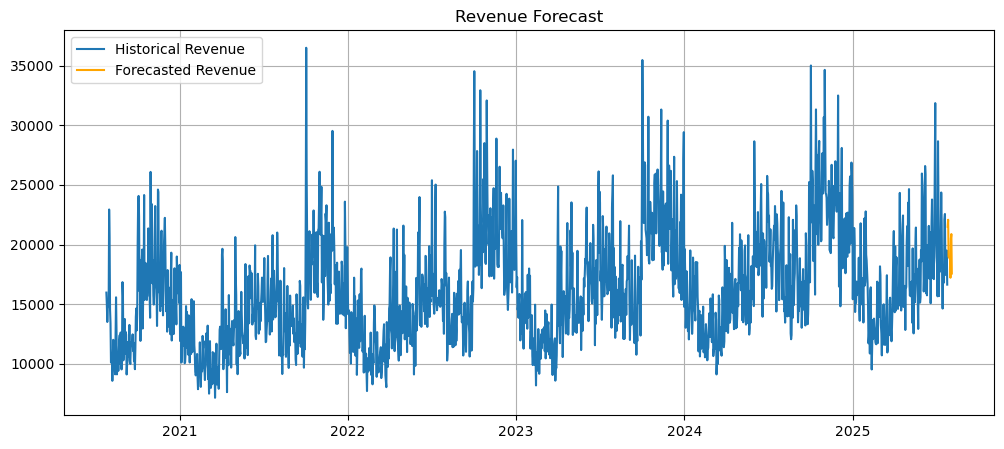

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ----------------- Parameters -----------------
SEQ_LEN = 29  # Number of past days to use for prediction
FORECAST_DAYS = 10  # Number of future days to predict

# ----------------- Load Data -----------------
revenue_df = pd.read_csv("data/shop_revenue_data.csv", parse_dates=['date'])
calendar_df = pd.read_csv("data/calendar_table.csv", parse_dates=['date'])

# Merge datasets
df = revenue_df.merge(calendar_df, on='date')

# Normalize revenue
scaler = MinMaxScaler()
df['revenue_scaled'] = scaler.fit_transform(df[['revenue']])

# ----------------- Create Sequences -----------------
def create_dataset(df, seq_len):
    X_revenue_seq, X_features, y = [], [], []

    for i in range(seq_len, len(df)):
        revenue_seq = df['revenue_scaled'].iloc[i-seq_len:i].values.reshape(-1, 1)  # (seq_len, 1)
        features = df[['weekend', 'public_holiday', 'distance_from_start_of_month', 'distance_from_end_of_month']].iloc[i].values
        target = df['revenue_scaled'].iloc[i]

        X_revenue_seq.append(revenue_seq)
        X_features.append(features)
        y.append(target)

    return np.array(X_revenue_seq), np.array(X_features), np.array(y)

X_seq, X_feat, y = create_dataset(df, SEQ_LEN)

# ----------------- Train/Test Split -----------------
train_size = int(len(X_seq) * 0.9)
X_seq_train, X_feat_train, y_train = X_seq[:train_size], X_feat[:train_size], y[:train_size]
X_seq_test, X_feat_test, y_test = X_seq[train_size:], X_feat[train_size:], y[train_size:]

# ----------------- Build LSTM Model -----------------
# Revenue sequence input
seq_input = Input(shape=(SEQ_LEN, 1), name='seq_input')
lstm_out = LSTM(64, activation='tanh')(seq_input)

# Calendar feature input
feat_input = Input(shape=(4,), name='calendar_input')

# Combine and output
combined = Concatenate()([lstm_out, feat_input])
output = Dense(1, activation='linear')(combined)

model = Model(inputs=[seq_input, feat_input], outputs=output)
model.compile(optimizer='adam', loss='mse')

# ----------------- Train Model -----------------
model.fit([X_seq_train, X_feat_train], y_train, epochs=20, batch_size=32, validation_split=0.1)

# ----------------- Forecast Future -----------------
def forecast_next_days(df, forecast_days, seq_len):
    predictions = []

    df_copy = df.copy()
    seq = df_copy['revenue_scaled'].iloc[-seq_len:].values.reshape(-1, 1)

    for i in range(forecast_days):
        # Date for which we're predicting
        next_date = df_copy['date'].iloc[-1] + pd.Timedelta(days=1)

        # Get calendar features
        cal_row = calendar_df[calendar_df['date'] == next_date]
        if cal_row.empty:
            print(f"No calendar data for {next_date}")
            break

        features = cal_row[['weekend', 'public_holiday', 'distance_from_start_of_month', 'distance_from_end_of_month']].values[0]

        # Predict
        pred_scaled = model.predict([seq.reshape(1, seq_len, 1), features.reshape(1, -1)], verbose=0)[0][0]
        pred = scaler.inverse_transform([[pred_scaled]])[0][0]
        predictions.append((next_date, pred))

        # Append predicted value for rolling sequence
        seq = np.vstack([seq[1:], [[pred_scaled]]])
        df_copy = pd.concat([df_copy, pd.DataFrame({'date': [next_date], 'revenue_scaled': [pred_scaled]})], ignore_index=True)

    return pd.DataFrame(predictions, columns=['date', 'predicted_revenue'])

# ----------------- Run Forecast -----------------
forecast_df = forecast_next_days(df, FORECAST_DAYS, SEQ_LEN)
forecast_df.to_csv("revenue_forecast.csv", index=False)

print("Forecast complete. Saved to revenue_forecast.csv")

# Optional plot
plt.figure(figsize=(12, 5))
plt.plot(revenue_df['date'], revenue_df['revenue'], label="Historical Revenue")
plt.plot(forecast_df['date'], forecast_df['predicted_revenue'], label="Forecasted Revenue", color='orange')
plt.title("Revenue Forecast")
plt.legend()
plt.grid(True)
plt.show()


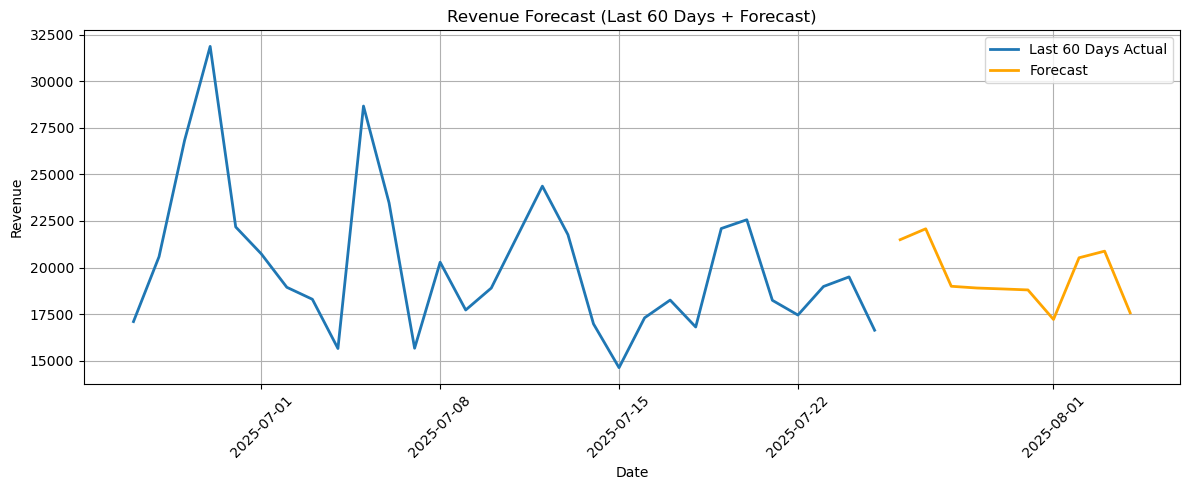

In [12]:
# Plot last 60 days + forecast
plt.figure(figsize=(12, 5))

# Filter last 60 days of historical revenue
last_60_actuals = revenue_df[revenue_df['date'] >= revenue_df['date'].max() - pd.Timedelta(days=29)]

# Plot actuals and forecast
plt.plot(last_60_actuals['date'], last_60_actuals['revenue'], label="Last 60 Days Actual", linewidth=2)
plt.plot(forecast_df['date'], forecast_df['predicted_revenue'], label="Forecast", color='orange', linewidth=2)

plt.title("Revenue Forecast (Last 60 Days + Forecast)")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
# Save model
model.save("models/lstm_revenue_model.h5")

# Save scaler
import joblib
joblib.dump(scaler, "models/revenue_scaler.save")


['models/revenue_scaler.save']

In [14]:
import json
from tensorflow.keras.models import load_model
import joblib
import pandas as pd
import numpy as np

# Load model and scaler
model = load_model("models/lstm_revenue_model.h5")
scaler = joblib.load("models/revenue_scaler.save")

# Load data
revenue_df = pd.read_csv("data/shop_revenue_data.csv", parse_dates=['date'])
calendar_df = pd.read_csv("data/calendar_table.csv", parse_dates=['date'])

# Merge
df = revenue_df.merge(calendar_df, on='date')
df['revenue_scaled'] = scaler.transform(df[['revenue']])
SEQ_LEN = 29

def forecast_revenue(n_days: int) -> str:
    predictions = []

    # 1. Add last 30 days of actual revenue
    recent_actuals = df.tail(30)
    for _, row in recent_actuals.iterrows():
        predictions.append({
            "date": row["date"].strftime("%Y-%m-%d"),
            "predicted_revenue": round(float(row["revenue"]), 2),
            "type": "actual"
        })

    # 2. Forecast next `n_days`
    df_copy = df.copy()
    seq = df_copy['revenue_scaled'].iloc[-SEQ_LEN:].values.reshape(-1, 1)

    for _ in range(n_days):
        next_date = df_copy['date'].iloc[-1] + pd.Timedelta(days=1)

        cal_row = calendar_df[calendar_df['date'] == next_date]
        if cal_row.empty:
            break

        features = cal_row[['weekend', 'public_holiday', 'distance_from_start_of_month', 'distance_from_end_of_month']].values[0]

        pred_scaled = model.predict([seq.reshape(1, SEQ_LEN, 1), features.reshape(1, -1)], verbose=0)[0][0]
        pred = float(scaler.inverse_transform([[pred_scaled]])[0][0])

        predictions.append({
            "date": next_date.strftime("%Y-%m-%d"),
            "predicted_revenue": round(pred, 2),
            "type": "forecast"
        })

        # Update sequence and df
        seq = np.vstack([seq[1:], [[pred_scaled]]])
        df_copy = pd.concat([df_copy, pd.DataFrame({'date': [next_date], 'revenue_scaled': [pred_scaled]})], ignore_index=True)

    return json.dumps(predictions, indent=2)

# Example usage
forecast_json = forecast_revenue(10)
print(forecast_json)


[
  {
    "date": "2025-06-26",
    "predicted_revenue": 17102.75,
    "type": "actual"
  },
  {
    "date": "2025-06-27",
    "predicted_revenue": 20584.99,
    "type": "actual"
  },
  {
    "date": "2025-06-28",
    "predicted_revenue": 26824.48,
    "type": "actual"
  },
  {
    "date": "2025-06-29",
    "predicted_revenue": 31862.06,
    "type": "actual"
  },
  {
    "date": "2025-06-30",
    "predicted_revenue": 22178.72,
    "type": "actual"
  },
  {
    "date": "2025-07-01",
    "predicted_revenue": 20737.0,
    "type": "actual"
  },
  {
    "date": "2025-07-02",
    "predicted_revenue": 18943.06,
    "type": "actual"
  },
  {
    "date": "2025-07-03",
    "predicted_revenue": 18300.24,
    "type": "actual"
  },
  {
    "date": "2025-07-04",
    "predicted_revenue": 15660.42,
    "type": "actual"
  },
  {
    "date": "2025-07-05",
    "predicted_revenue": 28663.0,
    "type": "actual"
  },
  {
    "date": "2025-07-06",
    "predicted_revenue": 23474.13,
    "type": "actual"
  },